<center>

# Supervised Learning Classification Project
## Hypertension risk

</center>

***Ideas***

- We can use Voting classifier with Grid/Rand search to evaluate optimized params for each estimator [here](https://scikit-learn.org/stable/modules/ensemble.html#using-the-votingclassifier-with-gridsearchcv)

- [Validation curve](https://scikit-learn.org/stable/modules/learning_curve.html#validation-curve) to plot the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values.

- Use PrecisionRecallDisplay to plot precision-recall curve. [Article on PR curve](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)

- Check this link and see impact of increasing the training data on the system's accuracy: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

✓  Need to explore the dataset biases

✓ Difference beween validation and test scores [here (StackEx)](https://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set)
Also see [this Medium article](https://medium.com/@alexstrebeck/training-and-testing-machine-learning-models-e1f27dc9b3cb) and [this article](https://machinelearningmastery.com/difference-test-validation-datasets/) : so that the error on the test set provides an unbiased estimate of the generalization error

- Write a point about [threshold value](https://stackoverflow.com/questions/19984957/scikit-learn-predict-default-threshold) (this can be just mentioned as way to deal with imbalanced dataset during presentation)

- **SelectFromModel** may be used for the 2nd objective ? [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)

✓ **Categorical variables skewness ?? Risk has been done, but what about the others ?**

**Notes**

- I systematically used cross-validation to evaluate the model's performance because the dataset is quite small so I am not confident that it is representative of the overall population.

**Tabs opened**

- https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

**Limitations**

- I chose to stick with RandomizedSearch : I might have missed optimal hyperparams, my params might only be quasi-optimal
- Criticze default params like cv=5 (StratifiedKFold) ?

https://www.kaggle.com/datasets/khan1803115/hypertension-risk-model-main/

### Hypertension Risk Dataset Objectives
- Establish a classification model as good as possible for hypertension risk prediction and assess its performance metrics
- Establish critical features correlated to hypertension risk

In [92]:
## Text formatting utility and helper functions for matplotlib

ansi = {
    'bold': '\033[1m',
    'underline': '\033[4m',
    'end': '\033[0m',
    'red': '\033[91m',
    'green': '\033[92m',
    'yellow': '\033[93m',
    'blue': '\033[94m',
    'magenta': '\033[95m',
    'cyan': '\033[96m',
}

def bold(text):
    return ansi['bold'] + str(text) + ansi['end']

def bold_red(text):
    return ansi['bold'] + ansi['red'] + str(text) + ansi['end']

def bold_blue(text):
    return ansi['bold'] + ansi['blue'] + str(text) + ansi['end']

def add_percentage(ax, total, color='white', y_offset=60):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() / 2 - y_offset
        ax.annotate(percentage, (x, y), ha='center', va='bottom', color=color, fontsize=12, fontweight='bold')

def set_xlabels_horizontal(ax):
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

## Dataset Overview

In [93]:
import pandas as pd
from matplotlib import pyplot as plt

hypertension_data = pd.read_csv('Hypertension-risk-model-main.csv', sep=',')

initial_rows_count = hypertension_data.shape[0]
print(initial_rows_count, "rows in the dataset")
hypertension_data.head()

4240 rows in the dataset


,male,age,currentSmoker,cigsPerDay,BPMeds,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Risk
0,1,39,0,0.0,0.0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


#### Assumptions
- heartRate feature indicates the heart rate in **resting** state (no prior effort)
- glucose level is _fasting_ blood glucose concentration and the unit is mg/dL
- total cholesterol unit's is mg/dL

## Data Preparation and Analysis

#### Skewness analysis of categorical variables

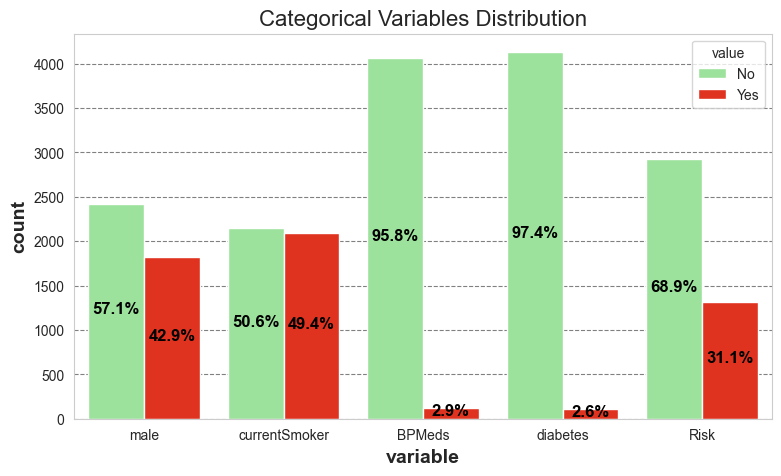

In [94]:
import pandas as pd
import seaborn as sns

categorical_columns = ['male', 'currentSmoker', 'BPMeds', 'diabetes', 'Risk']

df_categorical = hypertension_data.loc[:, categorical_columns].replace({0: 'No', 1: 'Yes'})

sns.set_style(style="whitegrid", rc={"grid.linestyle": '--', "grid.color": "0.5"})

plt.figure(figsize=(9, 5))
ax = sns.countplot(data=pd.melt(df_categorical), x='variable', hue='value', palette=['lightgreen', (1,0.1,0)], hue_order=['No', 'Yes'])

add_percentage(ax, len(hypertension_data), color='black')
ax.xaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontweight('bold')
ax.set_title('Categorical Variables Distribution', fontsize=16);

- We can see that the dataset is **skewed towards healthy subjects** (about 2 healthy subjects for 1 high risk subject).
- There is an **extreme bias** towards subjects not taking **BP medication** as well as those **not having diabetes**.

#### Missing values cleanup (brute-force approach)

In [95]:
import numpy as np

## TODO: draw a bar plot for the distribution of missing values in the dataset (see comment below) or a nullity matrix

# Check for all columns to be numeric
assert all(np.issubdtype(hypertension_data[col].dtype, np.number) for col in hypertension_data.columns), "Not all rows are numeric"

# Check for missing values in data (NaN or None)
missing_values_any = hypertension_data.isnull().any(axis=1)
missing_values_df = pd.DataFrame(hypertension_data.isnull().sum(), columns=['Count']).T
if missing_values_any.sum() != 0:
    print(f"{bold_red(missing_values_any.sum())} rows ({missing_values_df.sum(axis=1).values[0]} total NA values) with missing values in the data out of {hypertension_data.shape[0]}")
    display(missing_values_df)
    # missing_values_df.plot(title='Missing values distribution', y='Count', kind='bar');
else:
    print("No missing values in the data")

489 rows (540 total NA values) with missing values in the data out of 4240


,male,age,currentSmoker,cigsPerDay,BPMeds,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Risk
Count,0,0,0,29,53,0,50,0,0,19,1,388,0


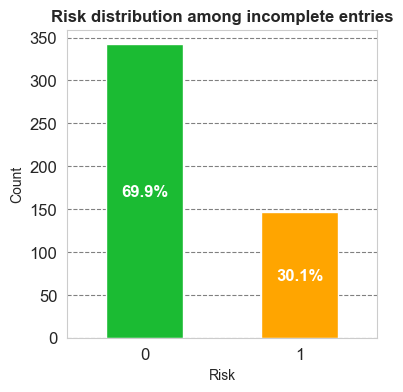

In [96]:
plt.ylabel('Count')
ax = hypertension_data[missing_values_any].groupby('Risk').size().plot(title='Risk distribution among incomplete entries',
                                                                  kind='bar', figsize=(4, 4), color=['#1BBB33','#FFA500'], fontsize=12);
ax.title.set_fontweight('bold')
ax.grid(axis='x', visible=False)
set_xlabels_horizontal(ax)
add_percentage(ax, missing_values_any.sum(), y_offset=10)

The bias in regards to the target is almost preserved among incomplete entries => removing them won't impact the initial bias by a lot.

In [97]:
# Missing values removal

hypertension_data.dropna(inplace=True)
print(bold_red(f"Removed {initial_rows_count - hypertension_data.shape[0]} entries"), "out of", initial_rows_count, "with brute-force approach (dropping rows with missing values)")
print(bold_blue(hypertension_data.shape[0]), "entries left in the dataset")

Removed 489 entries out of 4240 with brute-force approach (dropping rows with missing values)
3751 entries left in the dataset


In [98]:
# Check for duplicate entries
duplicates = hypertension_data.duplicated().sum()
if duplicates != 0:
    print(f"{bold_red(duplicates)} duplicate entries found in the data")
else:
    print("No duplicate entries found in the data")

No duplicate entries found in the data


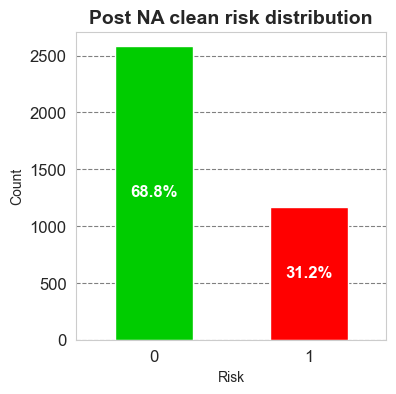

In [99]:
plt.ylabel('Count')
size_df = hypertension_data.groupby('Risk').size()
ax = size_df.plot(title='Post NA clean risk distribution', x='Risk', kind='bar',
                                              color=['#00CC00','#FF0000'], figsize=(4, 4), fontsize=12);

ax.title.set_fontweight('bold')
ax.title.set_fontsize(14)

# Add percentage labels on each bar
add_percentage(ax, size_df.sum())
ax.grid(axis='x', visible=False)
set_xlabels_horizontal(ax)

#### Outliers exploration (univariate analysis)

Number of outliers detected using Z-Score method: 205
Number of outliers detected using IQR method: 469
199 outliers detected by Z-Score method are also detected by IQR method


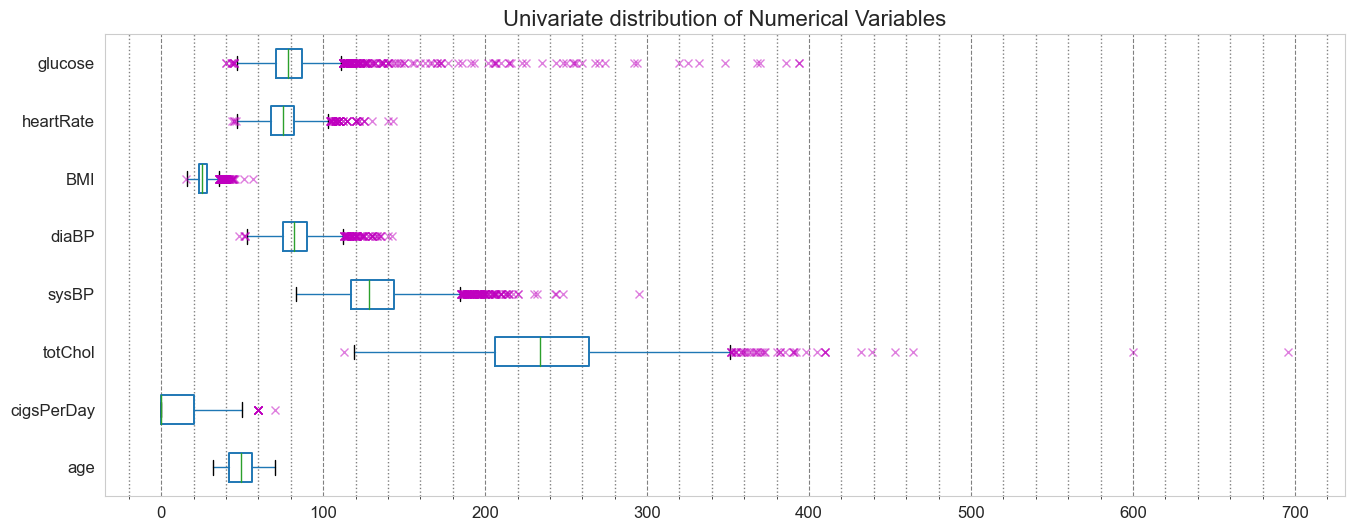

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore

# Horizontal boxplots
numerical_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
plot_return = hypertension_data[numerical_columns].boxplot(figsize=(16, 6), sym='xm', whis=1.5, flierprops=dict(alpha=0.5), return_type='both', vert=False, fontsize=12)
fliers, ax = plot_return[1]['fliers'], plot_return[0]
ax.set_title('Univariate distribution of Numerical Variables', fontsize=16)
plt.rcParams['xtick.minor.visible'] = True
ax.grid(which='minor', axis='x', linestyle=':', linewidth=1, visible=True)
plt.Axes.tick_params(ax, axis='x', which='minor', bottom=True)
ax.grid(which='major', axis='y', visible=False)

for line in plot_return[1]['boxes']:
    line.set_linewidth(1.4)

# Z-Score outlier detection
z_scores = zscore(hypertension_data[numerical_columns])
STD_DEV_THRESHOLD = 3 # 3 is 99.7% of the data, 2 is 95.4%
outliers_zscore = (np.abs(z_scores) > STD_DEV_THRESHOLD).any(axis=1)
outliers_zscore_count = outliers_zscore.sum()
print(f"Number of outliers detected using Z-Score method: {outliers_zscore_count}")

# Interquartile Range (IQR) outlier detection
whiskers = 1.5
Q1 = hypertension_data[numerical_columns].quantile(0.25)
Q3 = hypertension_data[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((hypertension_data[numerical_columns] < (Q1 - whiskers * IQR)) |
                (hypertension_data[numerical_columns] > (Q3 + whiskers * IQR))).any(axis=1)
outliers_iqr_count = outliers_iqr.sum()
print(f"Number of outliers detected using IQR method: {outliers_iqr_count}")

# IQR and Z-score outlier detection results comparison
zscore_in_IQR = hypertension_data[outliers_zscore].isin(hypertension_data[outliers_iqr]).any(axis=1).sum()
print(f"{zscore_in_IQR} outliers detected by Z-Score method are also detected by IQR method")

**Using IQR method for outliers detection when considering realistic values**

- Glucose levels: decrease lower bound to include outliers, increase upper bound to include outliers.
- Total cholesterol : bounds OK
- Diastolic & systolic : increase upper bound to include outliers for diastolic, OK for systolic
- 

In [101]:
for i, flier in enumerate(fliers):
    feature_outliers = flier.get_ydata().shape[0]
    print(f"{numerical_columns[i]}: {feature_outliers}")

age: 0
cigsPerDay: 11
totChol: 42
sysBP: 110
diaBP: 69
BMI: 86
heartRate: 81
glucose: 181


In [102]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Create the horizontal violin plot
# plt.figure(figsize=(16, 9))
# ax = sns.violinplot(data=hypertension_data[numerical_columns[::-1]], orient='h', linewidth=1.5, palette='Set2', alpha=0.5, saturation=1, inner='quartile')

# plt.rcParams['xtick.minor.visible'] = True
# ax.grid(which='minor', axis='x', linestyle=':', linewidth=0.8, visible=True)
# plt.Axes.tick_params(ax, axis='x', which='minor', bottom=True)
# ax.grid(which='major', axis='y', visible=False)

# plt.title('Distribution of Numerical Variables')
# plt.xlabel('Value')
# plt.ylabel('Variable')
# plt.show()

**Statistical comparison of the 2 methods**

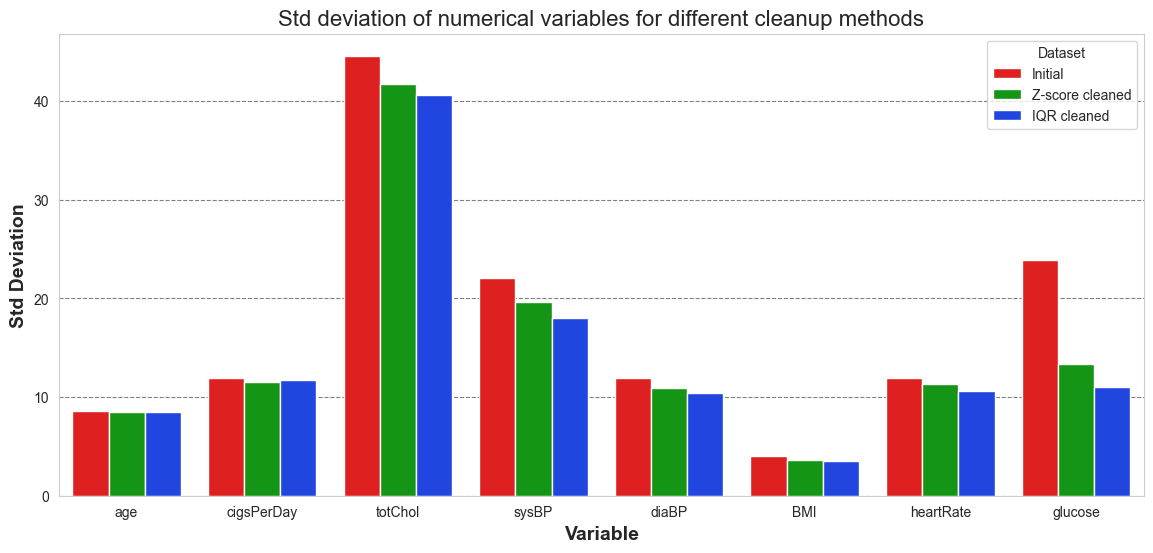

In [103]:
import pandas as pd

iqr_cleaned_std = hypertension_data[~outliers_iqr].std()

z_score_cleaned_std = hypertension_data[~outliers_zscore].std()

# Calculate the std of the dataset before cleanup
initial_std = hypertension_data.std()

# Create a dataframe with the std values
std_comparison_df = pd.DataFrame({'Initial': initial_std,'Z-score cleaned': z_score_cleaned_std, 'IQR cleaned': iqr_cleaned_std}).T.loc[:,numerical_columns]

# std_comparison_df.style.apply(lambda r:['background: yellow' if r.name == 'std(IQR cleaned dataset)' else '']*len(numerical_columns), axis=1)
# std_comparison_df.style.set_table_styles([dict(selector='th', props=[('background-color', '#000066'), ('color','white')])])

std_comparison_df = std_comparison_df.reset_index().rename(columns={'index': 'Dataset'})
std_comparison_df = std_comparison_df.melt(id_vars='Dataset', var_name='Variable', value_name='Std Deviation')

plt.figure(figsize=(14, 6));
ax = sns.barplot(data=std_comparison_df, x='Variable', y='Std Deviation', hue='Dataset', palette=['#FF0000', '#00AA00', '#0033FF']);
plt.title('Std deviation of numerical variables for different cleanup methods', fontsize=16);
ax.xaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontweight('bold')

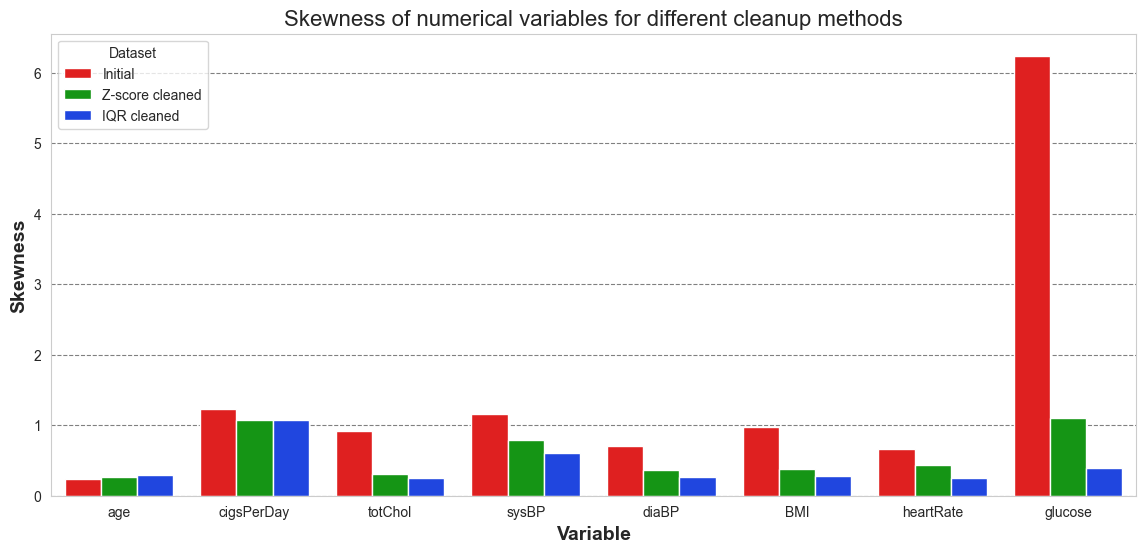

In [104]:
z_score_cleaned_skew = hypertension_data[~outliers_zscore].skew()
iqr_cleaned_skew = hypertension_data[~outliers_iqr].skew()

skewness_df = pd.DataFrame({'Initial': hypertension_data.skew(),'Z-score cleaned': z_score_cleaned_skew, 'IQR cleaned': iqr_cleaned_skew}).T.loc[:,numerical_columns]
skewness_df = skewness_df.reset_index().rename(columns={'index': 'Dataset'})
skewness_df = skewness_df.melt(id_vars='Dataset', var_name='Variable', value_name='Skewness')

plt.figure(figsize=(14, 6));
ax = sns.barplot(data=skewness_df, x='Variable', y='Skewness', hue='Dataset', palette=['#FF0000', '#00AA00', '#0033FF'])
plt.title('Skewness of numerical variables for different cleanup methods', fontsize=16)

ax.xaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontweight('bold')

['Initial' 'glucose' 59.432634538400784]


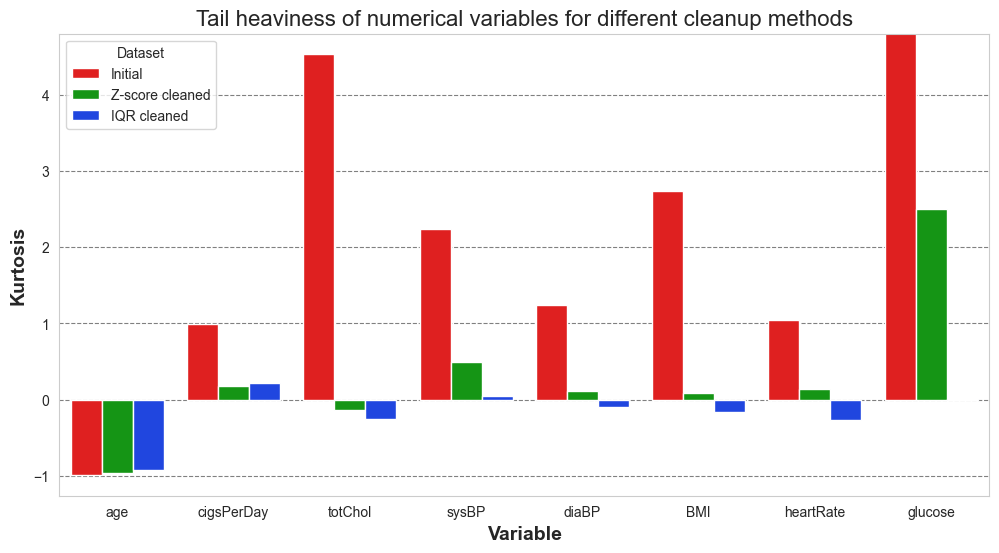

In [105]:
z_score_cleaned_kurtosis = hypertension_data[~outliers_zscore].kurtosis()
iqr_cleaned_kurtosis = hypertension_data[~outliers_iqr].kurtosis()

kurtosis_df = pd.DataFrame({'Initial': hypertension_data.kurtosis(),'Z-score cleaned': z_score_cleaned_kurtosis, 'IQR cleaned': iqr_cleaned_kurtosis}).T.loc[:,numerical_columns]
kurtosis_df = kurtosis_df.reset_index().rename(columns={'index': 'Dataset'})
kurtosis_df = kurtosis_df.melt(id_vars='Dataset', var_name='Variable', value_name='Kurtosis')

plt.figure(figsize=(12, 6));
ax = sns.barplot(data=kurtosis_df, x='Variable', y='Kurtosis', hue='Dataset', palette=['#FF0000', '#00AA00', '#0033FF'])
plt.title('Tail heaviness of numerical variables for different cleanup methods', fontsize=16)

ax.xaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontweight('bold')
ax.set_ylim(-1.26, 4.8)
print(kurtosis_df.loc[21].values)

plt.show()

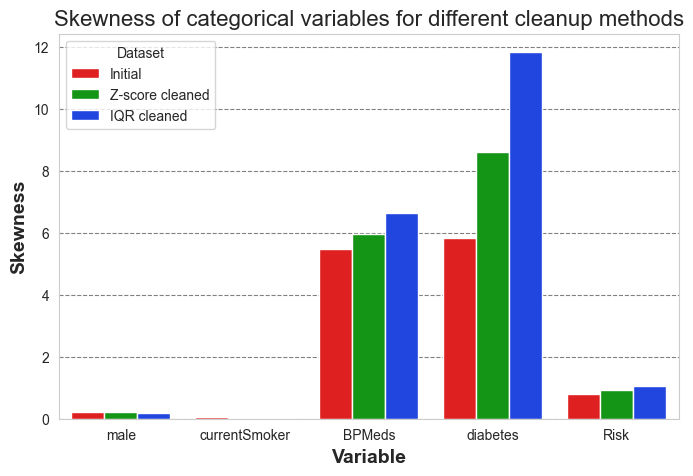

In [106]:
z_score_cleaned_skew = hypertension_data[~outliers_zscore].skew()
iqr_cleaned_skew = hypertension_data[~outliers_iqr].skew()

skewness_df = pd.DataFrame({'Initial': hypertension_data.skew(),'Z-score cleaned': z_score_cleaned_skew, 'IQR cleaned': iqr_cleaned_skew}).T.loc[:,categorical_columns]
skewness_df = skewness_df.reset_index().rename(columns={'index': 'Dataset'})
skewness_df = skewness_df.melt(id_vars='Dataset', var_name='Variable', value_name='Skewness')

plt.figure(figsize=(8, 5));
ax = sns.barplot(data=skewness_df, x='Variable', y='Skewness', hue='Dataset', palette=['#FF0000', '#00AA00', '#0033FF'])
plt.title('Skewness of categorical variables for different cleanup methods', fontsize=16)

ax.xaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontweight('bold')

We choose the **IQR method** (will remove more data points than Z-score).

**Justification for choosing IQR outliers removal over Z-score method**:

*Skewness*: IQR method decreases much more biases across the numerical variables, as well as their standard deviation.\
However, when considering categorical variables, it is slightly worse in regards to the target (we can ignore that for now), and really worse for diabetes and BPMeds.

*Kurtosis*: IQR produces higher and opposite kurtosis than Z-score method for BMI, heart rate and total cholesterol. It's better for glucose, age and sysBP. Overall, it is better than Z-score considering numerical variables.

Additionally, IQR outliers set mostly contains outliers detected by Z-score method.

**Further outliers investigation and handling**:
- A 4th method could be removing outliers based on realistic value ranges (according to health research institutions).
- We could use use a hybrid method IQR/Z-score, using IQR on certain variables and Z-score for others.
- We could use a more refined IQR method by adjusting per-variable whiskers to decrease the numbers of outliers removed with IQR

In [107]:
# Remove outliers using IQR method
hypertension_data_cleaned = hypertension_data[~outliers_iqr]

# Verify the number of rows after removing outliers
print(bold_red(f"Removed {outliers_iqr_count} outliers."))
print(bold_blue(hypertension_data_cleaned.shape[0]), "entries left in the dataset")

Removed 469 outliers.
3282 entries left in the dataset


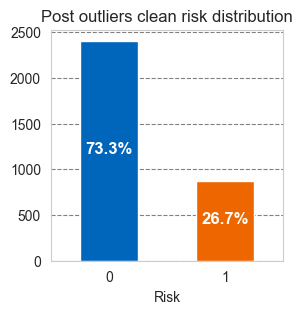

In [108]:
size_cleaned_df = hypertension_data_cleaned.groupby('Risk').size()

ax = size_cleaned_df.plot(title='Post outliers clean risk distribution', kind='bar',
                                              color=['#0066BB','#EE6600'], figsize=(3, 3));

# Add percentage labels on each bar
add_percentage(ax, size_cleaned_df.sum())

set_xlabels_horizontal(ax)
ax.grid(axis='x', visible=False)

#### Bivariate analysis (post outliers cleanup)

In [109]:
# Checking for weird values in the dataset

print("Diastolic is higher than systolic pressure in", hypertension_data_cleaned[hypertension_data_cleaned['diaBP'] > hypertension_data_cleaned['sysBP']].shape[0], "cases.")

Diastolic is higher than systolic pressure in 0 cases.


<Figure size 640x480 with 0 Axes>

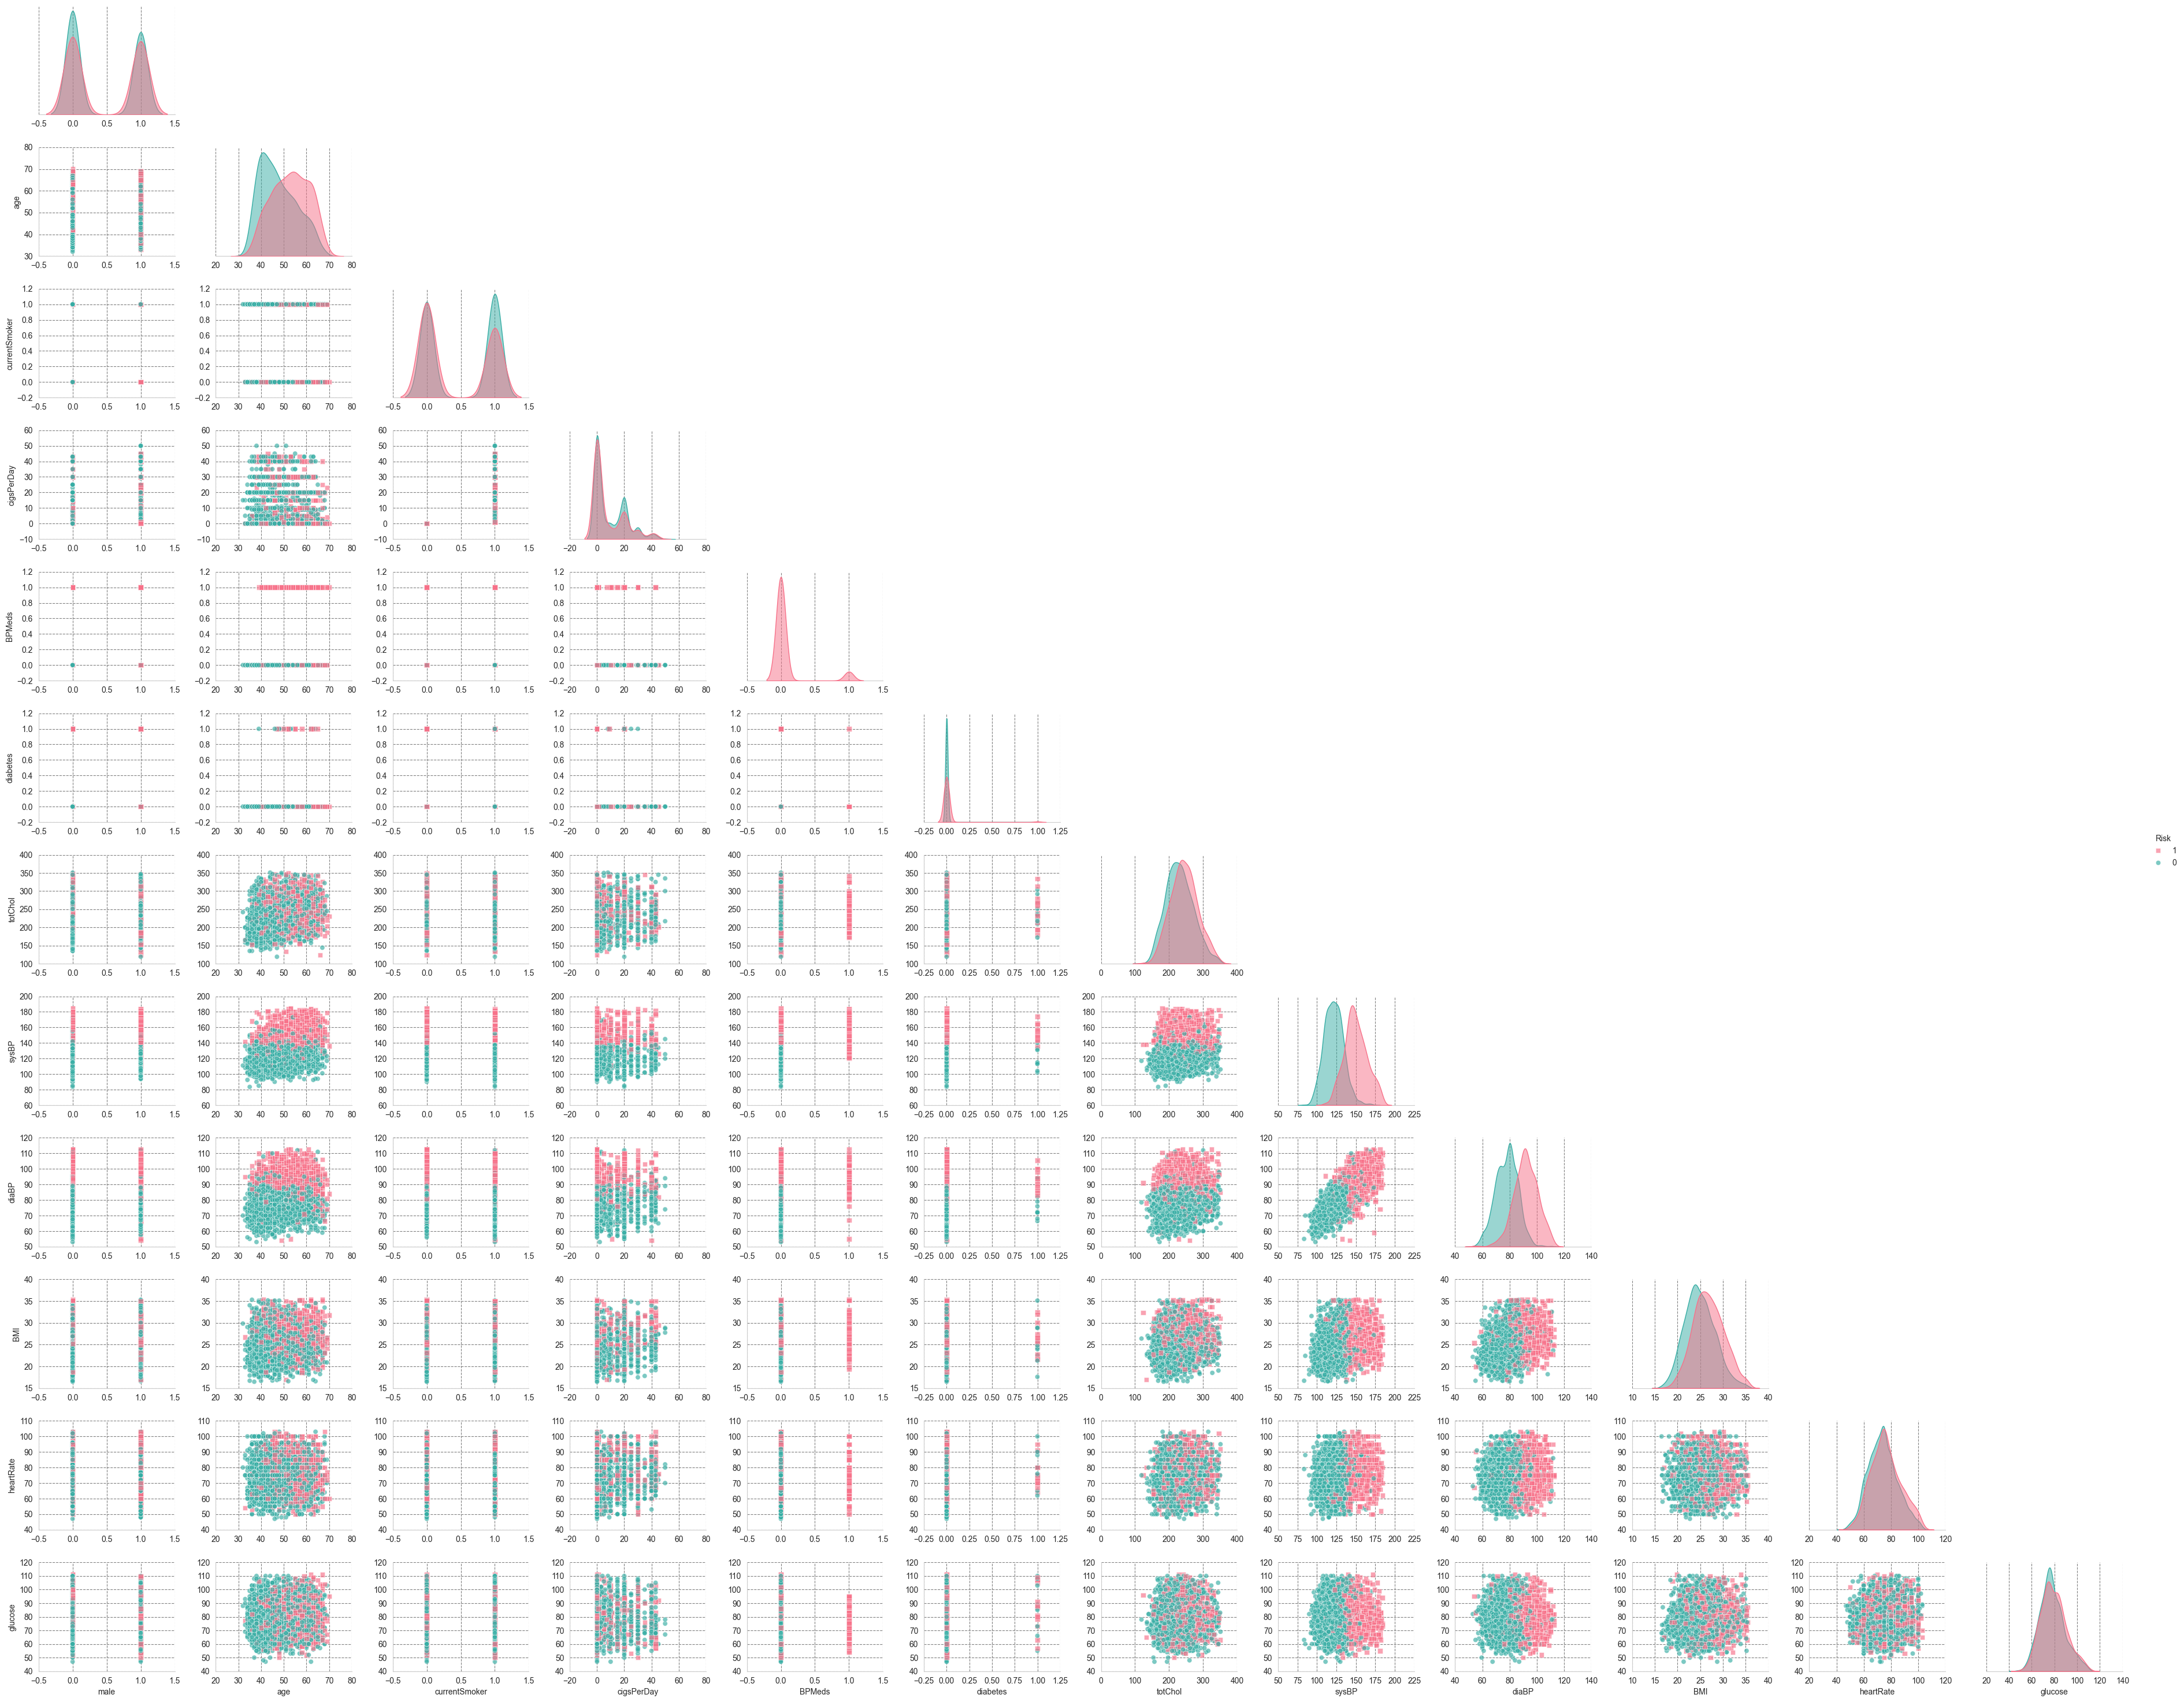

In [110]:
# import seaborn as sns

plt.figure(dpi=100)
g = sns.pairplot(hypertension_data_cleaned, hue="Risk", palette="husl", corner=True, hue_order=[1, 0], plot_kws={'alpha': 0.65},
                 diag_kws={'common_norm': False, 'fill': True, 'alpha': 0.5}, markers=['o', 's'], height=2.5, aspect=1.25)
                #  diag_kind='hist', diag_kws={'bins': 10})

# Add ticks with numbers to axes on every subplot
for ax in g.axes.flat:
  if ax is not None:
    ax.tick_params(axis='both', labelleft=True, labelbottom=True)
    ax.set_xticks(ax.get_xticks())
    ax.set_yticks(ax.get_yticks())

plt.subplots_adjust(wspace=0.3, hspace=0.3);

Looking at the diagonal, the univariate plots of diastolic and systolic BP as well as he 2D plot sysBP vs diaBP show a clear correlation between BP and hypertension.

Older people seem to have a higher chance of having hypertension according to the univariate distribution of age.

People with higher cholesterol and higher BMI might also have a slightly higher chance.

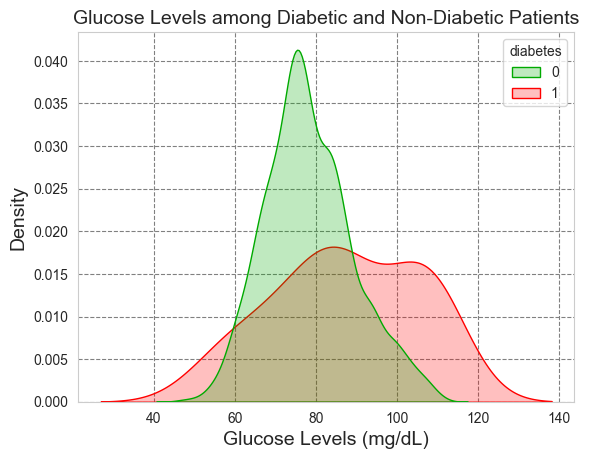

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.kdeplot(data=hypertension_data_cleaned, x='glucose', hue='diabetes', fill=True, common_norm=False, palette=['#00AA00','#FF0000'])

plt.xlabel('Glucose Levels (mg/dL)')
plt.ylabel('Density')
plt.title('Glucose Levels among Diabetic and Non-Diabetic Patients', fontsize=14)

ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)

plt.show()

Diabetic patients mostly don't have their glucose levels above 125 mg/dL, which is surprising if we consider WHO's statement that they should be diagnosed with diabetes. An explanaton could be that they have insulin intakes, which doesn't make them outliers.\
Non-diabetic patients mostly have healthy glucose levels.

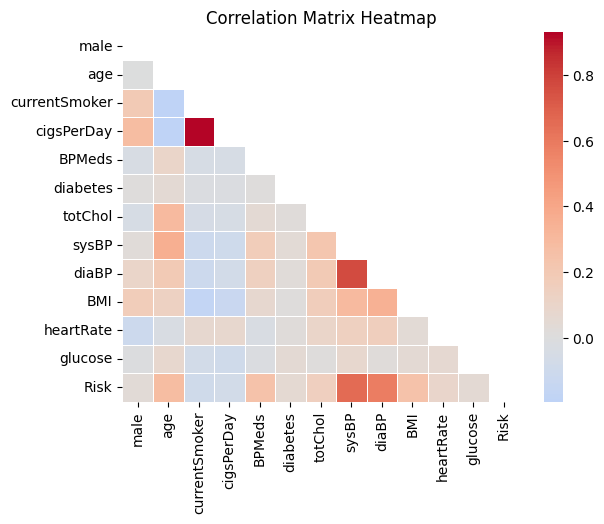

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = hypertension_data_cleaned.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=False, center=0, linewidths=0.5, fmt=".1f")

plt.title('Correlation Matrix Heatmap')
plt.show()

**Glucose levels**:\
Healthy glucose levels are 70-100 mg/dL. 100 to 125 mg/dL is moderately elevated. Beyond 125 mg/dL, diabetes is diagnosed. Below 70 is hypoglycemia.\
(*WHO*)

**Total cholesterol levels**:\
Healthy total cholesterol levels is below 200 mg/dL. 200 to 240 mg/dL is moderately elevated. Beyond that is high.\
(*Journal of the American College of Cardiology (JACC)*)

**Blood pressure levels**:\
Low sys,dia < 90/60 (hypotension)\
Healthy sys,dia between 90/60 and 120/80\
High sys,dia > 135/85\
(*NHS*)\
Highest < 190/100


## Model Selection and Training

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = hypertension_data_cleaned.drop('Risk', axis=1), hypertension_data_cleaned['Risk']

# Split the data into training and testing sets
# MUST split the data before scaling to avoid data leakage from test set to training set
TEST_SPLIT_PORTION = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SPLIT_PORTION, random_state=42)

# # Feature scaling
# std_scaler = StandardScaler()
# X_train_scaled = std_scaler.fit_transform(X_train)
# X_test_scaled = std_scaler.transform(X_test) # Apply the same transformation to the test set

def scale_data(X_train, X_test=None):
    std_scaler = StandardScaler()
    X_train_scaled = std_scaler.fit_transform(X_train)
    if X_test is not None:
        X_test_scaled = std_scaler.transform(X_test) # Apply the same transformation to the test set
        return X_train_scaled, X_test_scaled
    else:
        return X_train_scaled

X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

X_train2 = X_train.drop("currentSmoker", axis=1)
X_train3 = X_train2.drop("BPMeds", axis=1)
X_train4 = X_train3.drop("diabetes", axis=1)

In [95]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler

def fit_scaled_and_cross_validate(X_train, y_train, model):
    X_train_scaled = StandardScaler().fit_transform(X_train)
    
    model.fit(X_train_scaled, y_train)
    
    for scoring in ['recall', 'precision']:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=RepeatedStratifiedKFold(n_repeats=3), n_jobs=-1, scoring=scoring)
        print(f"Cross-Validation {scoring.capitalize()}:", round(scores.mean()*100, 1), "%")

#### **Random Forest Classifier**

We start with **RF classifier**. We will try to get the highest results with it.

Then, we can try to do feature reduction and optimization. (like remove highly correlated features)

Then we will try other classifiers (Logistic and SVM) with ensemble learning by means of the hard voting classifier.

We might then go back to data prep to see if we can improve the maximum results we got by tweaking the params on the models.

**Chosen metrics**

Picked metrics are **F1 and recall**. We don't use ROC AUC because we care more about false negatives than false positives (ROC AUC cares equally about them) and our classes are imbalanced. However, we need to keep in mind that F1 and recall scores are for a fixed threshold and do not consider all possible thresholds.

[ROC vs Precision-recall curves on imbalanced dataset (StackEx)](https://stats.stackexchange.com/questions/262616/roc-vs-precision-recall-curves-on-imbalanced-dataset)

**Default Random Forest Params**:

- n_estimators: 100
- criterion: 'gini'
- max_depth: None
- max_features: sqrt
- min_samples_split: 2
- min_samples_leaf: 1
- max_samples: 1.0
- max_leaf_nodes: None

**Hyperparameters optimization**

I started to use Grid Search but considering the amount of resources (time) it was taking, I moved on to Randomized Search

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_dist = {
    'n_estimators': [500],
    'max_features': [0.6, 0.7, 0.9],
    # 'max_depth': [None, 10, 25, 50],
    'min_samples_split': [5, 10, 20],
    'max_samples': [0.7, 0.9],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 16, 32],
    'criterion': ['gini', 'entropy', 'log_loss']
}

# Initialize a Random Forest classifier
rf = RandomForestClassifier()

# Initialize a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2, scoring='recall')

# Fit the RandomizedSearchCV object to your data
random_search.fit(X_train_scaled, y_train)

# Print the best parameters
print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': 0.65, 'max_leaf_nodes': 16, 'max_features': 0.9, 'criterion': 'log_loss'}
Best score: 91.5


**Results of RF param search**:

- With basic params ; 85.8 % recall & 80.3 % F1
- With max_leaf_nodes=32, max_samples=0.7, max_features=0.7 ; 87.7% and 80.7% (manual tweaking)

Found with RSearchCv using recall as scoring:
- {'n_estimators': 500, 'min_samples_split': 5, 'max_samples': 0.9, 'max_leaf_nodes': 16, 'max_features': 0.7} 89.5% recall 80.8% F1
- {'n_estimators': 500, 'min_samples_split': 10, 'max_samples': 0.9, 'max_leaf_nodes': 16, 'max_features': 0.7, 'criterion': 'entropy'} 90.1% & 80.7% F1 (to find this, I set up the params of the search to include the previous params and added new values to params and other params as well)
- **Best {'n_estimators': 500, 'min_samples_split': 10, 'max_samples': 0.65, 'max_leaf_nodes': 16, 'max_features': 0.9, 'criterion': 'log_loss'}** 90.1% & 84.1% F1

Cross-Validation Recall: 90.5 %
Cross-Validation Precision: 78.9 %


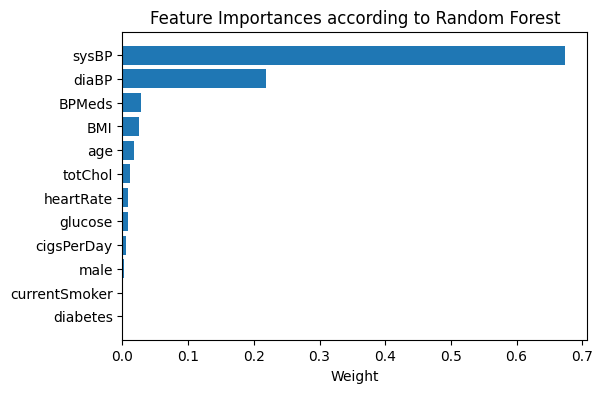

In [72]:
from sklearn.ensemble import RandomForestClassifier

## TODO: Print feature importances as a graph

rf_optimal_params = {'n_estimators': 500, 'min_samples_split': 10, 'max_samples': 0.65, 'max_leaf_nodes': 16, 'max_features': 0.9, 'criterion': 'log_loss'}
rf_best_clf = RandomForestClassifier(**rf_optimal_params, random_state=42)
# rf_best_clf.fit(X_train_scaled, y_train)

fit_scaled_and_cross_validate(X_train_scaled, y_train, rf_best_clf)

# for feature, importance in feature_importances:
#     print(f"{feature}: {importance:.3f}")

def plot_rf_feature_importances(importances, feature_names):
    feature_importances = list(zip(feature_names, importances))
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=False)

    plt.figure(figsize=(6, 4))
    plt.barh(range(len(feature_importances)), [importance for _, importance in feature_importances], align='center')
    plt.yticks(range(len(feature_importances)), [feature for feature, _ in feature_importances])
    plt.xlabel('Weight')
    plt.title('Feature Importances according to Random Forest')
    plt.show()

plot_rf_feature_importances(rf_best_clf.feature_importances_, hypertension_data_cleaned.columns[:-1])

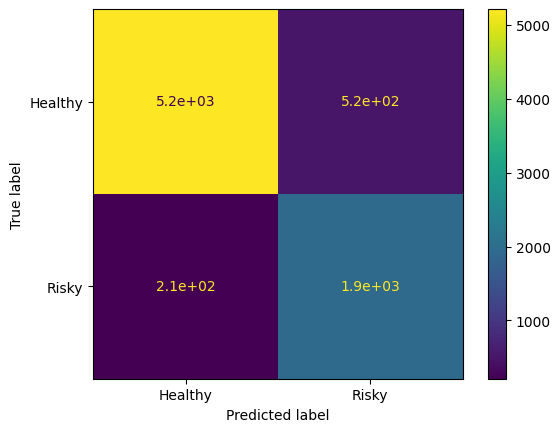

In [141]:
# Try to build the confusion matrix from cross validation scores without cross_val_predict because it would be inaccurate

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# # Initialize an empty confusion matrix
# conf_matrix = np.zeros((2, 2))

# # Initialize a RepeatedStratifiedKFold object
# rskf = RepeatedStratifiedKFold(n_repeats=3)

# # Iterate over the training indices and test indices from the RepeatedStratifiedKFold object
# for train_index, test_index in rskf.split(X_train_scaled, y_train):
#     # Fit the model to the training data
#     rf_best_clf.fit(X_train_scaled[train_index], y_train.iloc[train_index])
#     # Predict the labels of the test set
#     y_pred = rf_best_clf.predict(X_train_scaled[test_index])
#     # Update the confusion matrix
#     conf_matrix += confusion_matrix(y_train.iloc[test_index], y_pred)

# # Display the confusion matrix
# ConfusionMatrixDisplay(conf_matrix, display_labels=['Healthy', 'Risky']).plot();

We will now try to see if Random Forest classifier could benefit from **more training data**, making it worth to go back to the data prep step (to try imputation instead of brute force for instance) for this specific classifier. We will use the learning curve to do so.

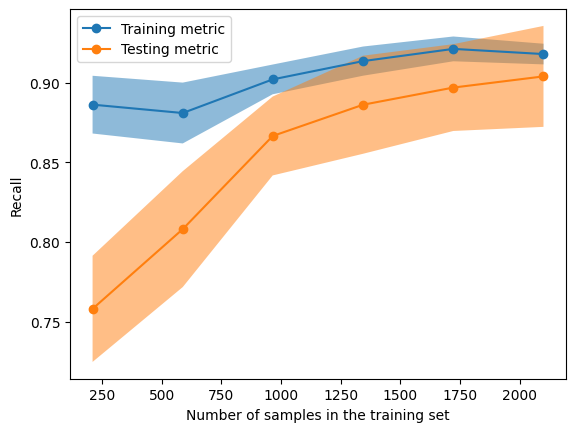

In [50]:
from sklearn.model_selection import LearningCurveDisplay

LearningCurveDisplay.from_estimator(rf_best_clf, X_train_scaled, y_train, train_sizes=np.linspace(0.1, 1, 6), cv=RepeatedStratifiedKFold(n_repeats=3), scoring='recall',
                                    score_name='Recall', score_type='both', line_kw={"marker": "o"}, n_jobs=-1, random_state=42);

It seems that acquiring more training data will not be useful as we reached some sort of plateau on the validation recall score.

**Feature selection**

Let's now try to select features according to data analysis and feature importances

Training best RF model without 'currentSmoker' feature
Cross-Validation Recall: 89.6 %
Cross-Validation Precision: 78.7 %


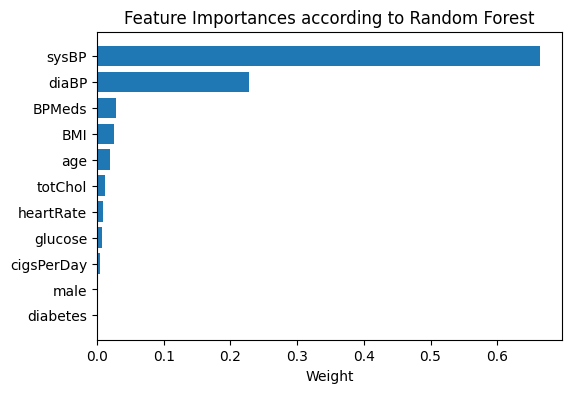

Training best RF model without 'currentSmoker' and 'diaBP' features
Cross-Validation Recall: 79.6 %
Cross-Validation Precision: 82.4 %


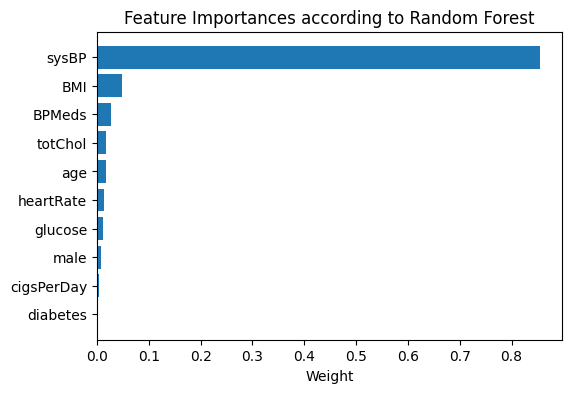

In [32]:
# Removing currentSmoker feature because it has a low feature importance and it has high correlation with cigsPerDay
print(bold("Training best RF model without 'currentSmoker' feature"))
fit_scaled_and_cross_validate(X_train2, y_train, rf_best_clf)
plot_rf_feature_importances(rf_best_clf.feature_importances_, X_train2.columns)

# Removing diaBP feature because it is highly correlated with sysBP
print(bold("Training best RF model without 'currentSmoker' and 'diaBP' features"))

X_train_rf_diaBP = X_train2.drop("diaBP", axis=1)
fit_scaled_and_cross_validate(X_train_rf_diaBP, y_train, rf_best_clf)
# plot_rf_feature_importances(rf_best_clf.feature_importances_, X_train3.columns)

In [95]:
X_train_rf_merge_BP = X_train2.copy()

# Create the new feature 'sysDiaBP'
X_train_rf_merge_BP['sysDiaBP'] = X_train2['sysBP'] + X_train2['diaBP']

X_train_rf_merge_BP.drop(['sysBP', 'diaBP'], axis=1, inplace=True)

print("Training best RF model with new 'sysDiaBP' feature")
fit_scaled_and_cross_validate(X_train_rf_merge_BP, y_train, rf_best_clf)

Training best RF model with new 'sysDiaBP' feature
Cross-Validation Recall: 82.1 %
Cross-Validation Precision: 79.8 %


Training best RF model without currentSmoker, male and diabetes features (6 features left)
Cross-Validation Recall: 90.1 %
Cross-Validation Precision: 79.1 %


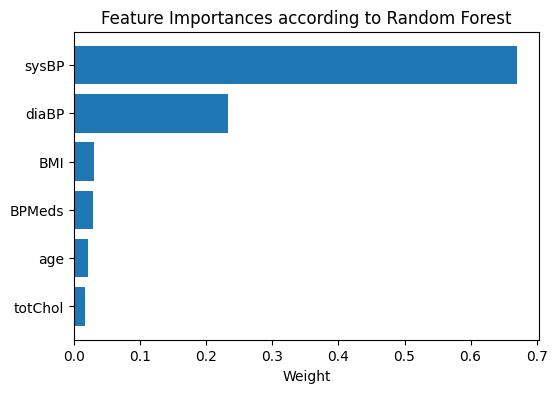

In [100]:
X_train_rf = X_train2.drop(['male', 'diabetes', 'glucose', 'cigsPerDay', 'heartRate'], axis=1)
print(f"Training best RF model without currentSmoker, male and diabetes features ({X_train_rf.shape[1]} features left)")
fit_scaled_and_cross_validate(X_train_rf, y_train, rf_best_clf)
plot_rf_feature_importances(rf_best_clf.feature_importances_, X_train_rf.columns)

#### **Support Vector Machine classifier**

**Default Support Vector Machine Params**

- C: 1
- kernel: rbf
- degree: 3
- gamma: scale
- probability: False
- class_weight: None
- max_iter: -1
- decision_function_shape: ovr
- tol: 1e-3
- shrinking: True
- break_ties: False

In [76]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 'scale', 'auto', 1, 0.01],
    'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
    'degree': [2, 3, 4, 5],
    'probability': [False, True],
    'class_weight': ['balanced'],
    # 'max_iter': [1000],
    'shrinking': [True, False],
    # 'tol': [1e-3],
    'decision_function_shape': ['ovo', 'ovr'],
    # 'break_ties': [True, False],
}

# Initialize a Random Forest classifier
svc = SVC(random_state=42, cache_size=1800)

# Initialize a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=svc, param_distributions=param_dist, n_iter=100, cv=3, n_jobs=-1, verbose=2, scoring='recall')

X_train2_scaled = scale_data(X_train2)

# Fit the RandomizedSearchCV object to your data
random_search.fit(X_train2_scaled, y_train)

# Print the best parameters
print(random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'shrinking': False, 'probability': False, 'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'decision_function_shape': 'ovo', 'class_weight': 'balanced', 'C': 0.1}


In [100]:
from sklearn.svm import SVC

svc_optimal_params = {'class_weight': 'balanced', 'C': 1}
svc_best_clf = SVC(**svc_optimal_params, random_state=42)

fit_scaled_and_cross_validate(X_train, y_train, svc_best_clf)

Cross-Validation Recall: 89.1 %
Cross-Validation Precision: 73.2 %


**Results for SVC**

- 99.4 recall, 33.4 precision: ???
- 86.0 recall, 75.6 precision: {'shrinking': False, 'probability': True, 'kernel': 'poly', 'gamma': 1, 'degree': 2, 'class_weight': 'balanced'}
- 89.5 recall, 73.6 precision: {'class_weight': 'balanced', 'C': 1}

#### **Voting classifier**

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(random_state=42, n_jobs=-1)
rnd_clf = RandomForestClassifier(**rf_optimal_params, n_jobs=-1, random_state=42)
svm_clf = SVC(**{'degree': 2, 'class_weight': 'balanced', 'C': 1}, random_state=42)
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard', n_jobs=-1)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    print(f"[{clf.__class__.__name__}]")
    fit_scaled_and_cross_validate(X_train2, y_train, clf)
    # print(f"[{clf.__class__.__name__}] Cross-validation Recall {cross_val_score(clf, X_train_scaled, y_train, scoring='recall', n_jobs=-1).mean()*100:.1f}%")

[LogisticRegression]
Cross-Validation Recall: 75.2 %
Cross-Validation Precision: 84.6 %
[RandomForestClassifier]
Cross-Validation Recall: 91.0 %
Cross-Validation Precision: 78.6 %
[SVC]
Cross-Validation Recall: 89.3 %
Cross-Validation Precision: 72.9 %
[VotingClassifier]
Cross-Validation Recall: 86.9 %
Cross-Validation Precision: 80.3 %


### Final model performance assessment

(tn, fp, fn, tp), Test dataset size: 656


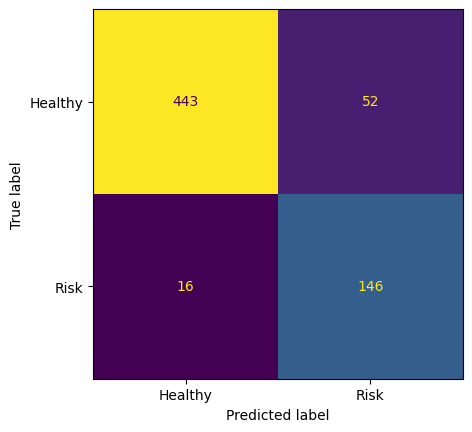

In [130]:
print(f"(tn, fp, fn, tp), Test dataset size: {int(TEST_SPLIT_PORTION * hypertension_data_cleaned.shape[0])}")

y_pred_on_test = rf_best_clf.predict(X_test_scaled)
confusion_mat = confusion_matrix(y_test, y_pred_on_test)
confusion_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=["Healthy", "Risky"])
confusion_display.plot(colorbar=False);